In [1]:
import os

using_colab = False
if using_colab:
  os.system('rm -rf ./*')
  os.system('git clone https://github.com/gasparyanartur/radio-optimizer.git')
  os.system('mv radio-optimizer/* ./')
  os.system('rm -rf radio-optimizer')

(no blockage)	PWM: PEB = 0.026133+0.000000j | CEB = 0.013426+0.000000j
(with blockage)	PWM: PEB = 0.069256+0.000000j | CEB = 0.064823+0.000000j


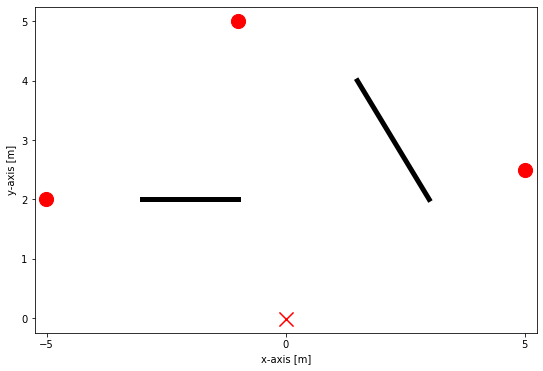

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time

from src.utils import db2pow, setup_fig

from src.channel_mmWave_parameters import ChannelmmWaveParameters

c = ChannelmmWaveParameters(
    PB = np.array([0, -0.01, 0]).reshape(-1, 1),
    OB = np.array([45, 0, 0]).reshape(-1, 1),
    NB_dim = np.array([1, 1]).reshape(-1, 1),
    PR = np.array([[-5.01, 2, 0.5], [-1, 5.01, 0.5], [5.01, 2.5, 0.5]]).T,
    OR = np.array([[0, 0, 0], [-90, 0, 0], [180, 0, 0]]).T,
    NR_dim = np.array([[10, 10], [10, 10], [10, 10]]).T,
    PU = np.array([-2, 3, -1.5]).reshape(-1, 1),
    OU = np.array([0, 0, 0]).reshape(-1, 1),
    NU_dim = np.array([1, 1]).reshape(-1, 1),
    P = db2pow(15),
    K = 64,
    G = 10,

    seed=1
)

c.get_beam_matrix()
c.get_tx_symbol()
c.get_path_parameters_PWM()
c.get_FIM_PWM()

fim = c.FIM
c.get_crlb_from_fim_PWM(fim)
print(f"(no blockage)\tPWM: PEB = {c.PEB:.6f} | CEB = {c.CEB:.6f}")

setup_fig()
c.plot_scene()

point = np.array([2, 4])
blockage = c.get_blockage(point)
c.get_crlb_blockage(blockage)

print(f"(with blockage)\tPWM: PEB = {c.PEB:.6f} | CEB = {c.CEB:.6f}")

c0 = c.copy()

In [3]:
grid_size = 0.5     # ~7s
#grid_size = 0.2     # ~42s
#grid_size = 0.1     # ~160s

xgrid = np.arange(-5, 5+grid_size, grid_size)
ygrid = np.arange(0, 5+grid_size, grid_size)
%prun PEB_cell = c.get_PEB_cell(xgrid, ygrid, parallel=True)

         657638 function calls (570518 primitive calls) in 7.508 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       20    7.042    0.352    7.042    0.352 {method 'acquire' of '_thread.lock' objects}
    30954    0.116    0.000    0.122    0.000 {method '__deepcopy__' of 'numpy.ndarray' objects}
85470/231    0.107    0.000    0.341    0.001 copy.py:128(deepcopy)
       12    0.048    0.004    0.048    0.004 {built-in method _winapi.CreateProcess}
        1    0.028    0.028    7.508    7.508 <string>:1(<module>)
      231    0.021    0.000    0.334    0.001 copy.py:226(_deepcopy_dict)
       94    0.021    0.000    0.021    0.000 {built-in method _winapi.WaitForSingleObject}
    38808    0.020    0.000    0.029    0.000 copy.py:242(_keep_alive)
   170506    0.018    0.000    0.018    0.000 {method 'get' of 'dict' objects}
   131208    0.013    0.000    0.013    0.000 {built-in method builtins.id}
     4389    0.010    0

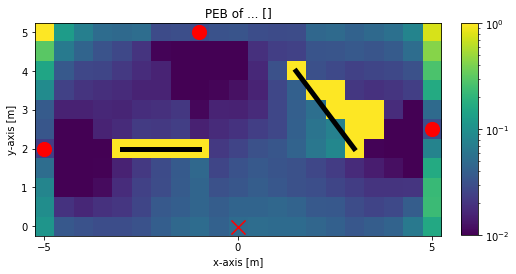

In [4]:

PEB_mat = PEB_cell.copy()
PEB_mat[np.isnan(PEB_cell) | (np.abs(PEB_cell) > 100)] = 100

X, Y = np.meshgrid(xgrid, ygrid)

margin = 0.25
cbar_shrink=0.65

setup_fig()
plt.title('PEB of ... []')
img = plt.imshow(PEB_mat.T.real, origin='lower', norm=mpl.colors.LogNorm(vmin=0.01, vmax=1), extent=[-5-margin, 5+margin, -margin, 5+margin])
plt.colorbar(img, pad=0.04, shrink=cbar_shrink, aspect=20*cbar_shrink)
c.plot_scene()

...;

In [5]:
"""
grid_size = 0.5     # ~7s
#grid_size = 0.2     # ~42s
#grid_size = 0.1     # ~160s


xgrid = np.arange(-5, 5+grid_size, grid_size)
ygrid = np.arange(0, 5+grid_size, grid_size)

PEB_mat = np.zeros((xgrid.size, ygrid.size))
PEB_cell = np.zeros((xgrid.size, ygrid.size), dtype='complex_')

print_runtimes = False
verbosity = 1

runtimes = np.zeros((xgrid.size, ygrid.size))

for xi in range(xgrid.size):
    if verbosity >= 1:
        print(f"xi: {xi}/{xgrid.size}")

    for yi in range(ygrid.size):
        if verbosity >= 2:
            print(f"yi: {yi}/{ygrid.size}")

        c = c0.copy()

        PU = np.array([xgrid[xi], ygrid[yi], 1]).reshape(-1, 1)

        t_start = time.time()
        PEB = c.get_PEB_from_PU(PU)
        t_end = time.time()

        PEB_cell[xi, yi] = c.PEB
        runtimes[xi, yi] = t_end - t_start
    
print(f"Total Runtime:\t{runtimes.sum():.3f} [s]")
print(f"Runtime per X:\t{runtimes.sum(axis=0).mean():.3f} ± {runtimes.sum(axis=0).std():.3f} [s]")
print(f"Runtime per Y:\t{runtimes.mean():.3f} ± {runtimes.std():.3f} [s]")   print(f"Total Runtime: {runtimes.sum(): .3f}s")
    
...;
""";

In [6]:
import numba as nb
nb.__version__



@nb.njit
def t():
    a = [1]
    return a    

t()

[1]